## Step 5 Setup — Load cleaned dataset and rebuild preprocessor

Since this notebook runs independently, we need to re-create `X_train`, `X_test`, `y_train`, `y_test`, and `preprocessor` from Step 4.


In [4]:
# Reload cleaned dataset
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load cleaned data
df = pd.read_csv("../data/data_processed/loan_clean.csv")

X = df.drop(columns=["target"])
y = df["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Identify column types
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Define pipelines again
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Rebuild preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numeric_cols),
        ("cat", cat_pipeline, categorical_cols)
    ]
)

print("✅ Setup complete — preprocessor rebuilt, train/test ready")


✅ Setup complete — preprocessor rebuilt, train/test ready


## Step 5B — Define Logistic Regression Pipeline

We combine our `preprocessor` with Logistic Regression (with `class_weight="balanced"` to handle class imbalance).


In [5]:
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear"))
])


## Step 5C — Train Logistic Regression

Fit the Logistic Regression pipeline on the training data.


In [6]:
log_reg_pipeline.fit(X_train, y_train)
print("✅ Logistic Regression model trained")


✅ Logistic Regression model trained


## Step 5D — Evaluate Logistic Regression

We predict on the test set, then calculate:
- Accuracy
- F1-score
- Confusion matrix
- Classification report
- ROC–AUC


Accuracy: 0.676
F1 Score: 0.334

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.67      0.79     45139
           1       0.22      0.70      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.73     51070



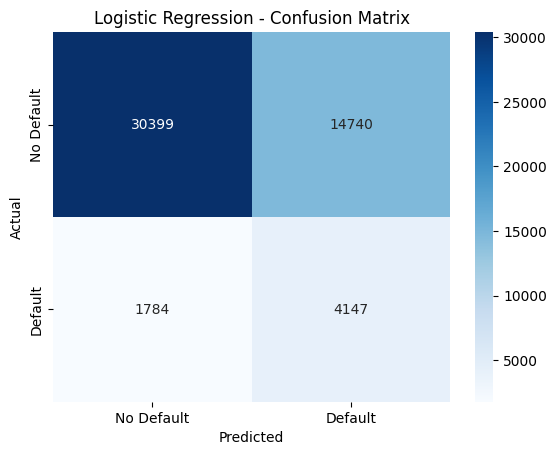

ROC–AUC: 0.753


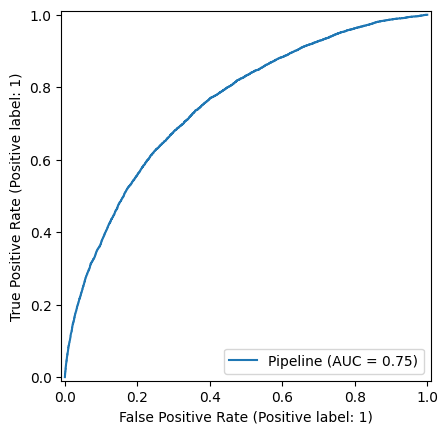

In [8]:
y_pred_lr = log_reg_pipeline.predict(X_test)
y_prob_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("F1 Score:", round(f1_score(y_test, y_pred_lr), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC–AUC
roc_auc = roc_auc_score(y_test, y_prob_lr)
print("ROC–AUC:", round(roc_auc, 3))

RocCurveDisplay.from_estimator(log_reg_pipeline, X_test, y_test)
plt.show()


## Step 5E — Define Decision Tree Pipeline

Now we train a Decision Tree classifier. We limit depth to avoid overfitting.


In [9]:
tree_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=10, class_weight="balanced", random_state=42))
])


## Step 5F — Train Decision Tree

Fit the Decision Tree pipeline on the training data.


In [11]:
tree_pipeline.fit(X_train, y_train)
print("✅ Decision Tree model trained")


✅ Decision Tree model trained


## Step 5G — Evaluate Decision Tree

We evaluate the Decision Tree using the same metrics as Logistic Regression.


Accuracy: 0.664
F1 Score: 0.31

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.67      0.78     45139
           1       0.20      0.65      0.31      5931

    accuracy                           0.66     51070
   macro avg       0.57      0.66      0.54     51070
weighted avg       0.85      0.66      0.72     51070



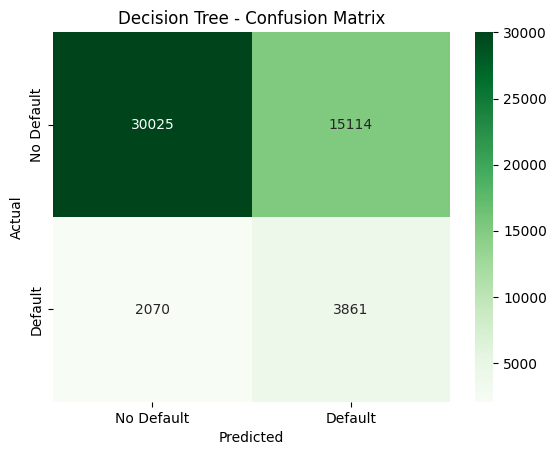

ROC–AUC: 0.707


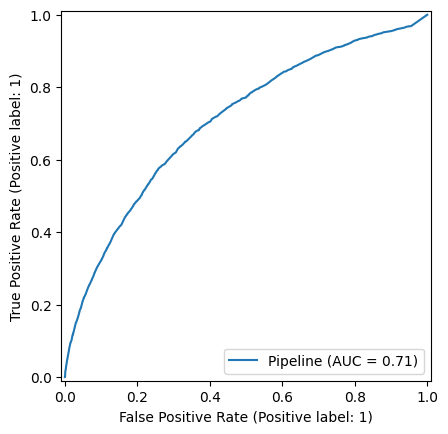

In [13]:
y_pred_tree = tree_pipeline.predict(X_test)
y_prob_tree = tree_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", round(accuracy_score(y_test, y_pred_tree), 3))
print("F1 Score:", round(f1_score(y_test, y_pred_tree), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC–AUC
roc_auc = roc_auc_score(y_test, y_prob_tree)
print("ROC–AUC:", round(roc_auc, 3))

RocCurveDisplay.from_estimator(tree_pipeline, X_test, y_test)
plt.show()


## Step 5H — Compare Models

We compare the performance of Logistic Regression and Decision Tree side by side.


In [14]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_tree)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_tree)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_tree)
    ]
})

print(results.round(3))


                 Model  Accuracy  F1 Score  ROC-AUC
0  Logistic Regression     0.676     0.334    0.753
1        Decision Tree     0.664     0.310    0.707


## Step 5I — Save Best Model

We compare ROC–AUC of Logistic Regression and Decision Tree.  
The model with higher ROC–AUC is selected as the best model and saved (with its preprocessing pipeline) into `../models/loan_default_model.pkl` using joblib.  
This file will be loaded later in Step 6 (Streamlit app) for deployment.


In [15]:
import joblib
import os

# Compare ROC–AUC
lr_auc = roc_auc_score(y_test, y_prob_lr)
tree_auc = roc_auc_score(y_test, y_prob_tree)

if lr_auc >= tree_auc:
    best_model = log_reg_pipeline
    best_name = "Logistic Regression"
    best_auc = lr_auc
else:
    best_model = tree_pipeline
    best_name = "Decision Tree"
    best_auc = tree_auc

# Ensure models folder exists
os.makedirs("../models", exist_ok=True)

# Save the best model
model_path = "../models/loan_default_model.pkl"
joblib.dump(best_model, model_path)

print(f"✅ Best model: {best_name} (ROC–AUC = {round(best_auc,3)})")
print(f"Model saved to: {model_path}")


✅ Best model: Logistic Regression (ROC–AUC = 0.753)
Model saved to: ../models/loan_default_model.pkl
